In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from read_roi import read_roi_zip
from collections import OrderedDict, Counter
import math
import PIL
from PIL import Image
from PIL.TiffTags import TAGS
import tkinter as tk
from tkinter import filedialog
import seaborn as sns

# Read, format and save raw data from ROIs #

In [2]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
path = Path(askdirectory)
path

WindowsPath('F:/Data/Images/2022-08-12_dynamics/2022-08-12_dynamics_Ch4-10uM-T2')

In [3]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

DCXconc = '[DCX] ' r'$(n M)$'
DCX = 'DCX'

investigator = 'Brandy'

In [13]:
dateloc = str(path).find("202")
date = str(path)[dateloc : dateloc+10]

folders = [x for x in path.iterdir() if x.is_dir()]
folders = [i for i in folders if (str(i)[-5:] == 'FINAL') == True]

ch = []
conc_tub = []
conc_DCX = []
DCX_type = []

for i in folders:
    CHloc = str(i).rfind("Ch")
    tubloc = str(i).rfind(tub)
    #DCXloc = str(i).rfind(DCX)
    #dcxtype = str(i).find("type")
    ch = ch + [str(i)[CHloc+2:CHloc+3]]
    conc_tub = conc_tub + [(str(i)[tubloc+3:tubloc+5])]
    #conc_DCX = conc_DCX + [(str(i)[DCXloc+3:DCXloc+6])]
    #DCX_type = DCX_type + [(str(i)[dcxtype+4:DCXloc-1])]

date,ch, conc_tub#, conc_DCX, DCX_type


('2022-08-12', ['4'], ['10'])

In [22]:
tub_conc =  [float(i) for i in conc_tub]
#DCX_conc =  [float(i) for i in conc_DCX]
frame_analyzer = pd.read_csv(path/'frame_rates_avg.csv',sep=',')
pixel =  0.107 #T2 0.107 #T1 0.0633
folders

[WindowsPath('F:/Data/Images/2022-08-12_dynamics/2022-08-12_dynamics_Ch4-10uM-T2/2022-08-12_dynamics_Ch4-tub10uM_FINAL')]

In [23]:
#frame_analyzer = frame_analyzer.iloc[[1,3]].reset_index()
frame_analyzer

,Directory,Mean,SD,Frames,Outliers,MeanWOutliers,SDWOutliers
0,F:\Data\Images\2022-08-12_dynamics\2022-08-12_...,5.04,0.02,400,1,10.31,105.43


In [24]:
def open_roi_poly(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','x3','y1','y2','y3'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x'][0],'x2': roi_data[key]['x'][1],'x3': roi_data[key]['x'][2],'y1': roi_data[key]['y'][0],'y2': roi_data[key]['y'][1],'y3': roi_data[key]['y'][2]}, ignore_index=True)
    return roi_df

def open_roi_line(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','y1','y2'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x1'],'x2': roi_data[key]['x2'],'y1': roi_data[key]['y1'],'y2': roi_data[key]['y2']}, ignore_index=True)
    return roi_df

In [26]:
open_roi_poly(0,'2022-08-12_Ch4-10uM_kymo-set1.zip')

,Track ID,x1,x2,x3,y1,y2,y3
0,0107-0100,43,158,41,13,195,201
1,0259-0081,39,123,45,201,312,316
2,0351-0063,46,84,42,316,385,385
3,0287-0080,128,28,131,201,368,373
4,0045-0081,55,106,58,15,74,75
5,0177-0121,58,188,53,72,269,281
6,0167-0136,28,245,26,13,308,321
7,0035-0044,30,58,30,13,56,56
8,0134-0077,29,127,27,56,208,211
9,0287-0067,30,107,27,212,356,362


In [25]:
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'
poly_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate)
line_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate)

In [27]:
def poly_dynamics(k):
        
    data = open_roi_poly(k,'2022-08-12_Ch4-10uM_kymo-set1.zip')
    supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data)
    pre_df = {'Date': np.full((n), date), 'Investigator': np.full((n), investigator),
              'CH': np.full((n), ch[k]),tubulin: np.full((n), tub_conc[k])}
    df = pd.DataFrame(pre_df) 
    
    df[Length] = abs((data['x2']-data['x1'])*pixel)
    
    data[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x[Lifetime] != 0 else np.NaN, axis=1)
    
    df[GrowthRate] = df[Length]/df[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NAN )
    
    df[TimeToNucleate] = (data['y1']-start)*spf/60
    
    df[ShrinkageLength] = abs((data['x3']-data['x2'])*pixel)
    df[ShrinkageLifetime] = abs((data['y3']-data['y2'])*spf/60)
    df[ShrinkageLifetime] = df[ShrinkageLifetime].apply(lambda x: np.NAN if x == 0 else x)
    df[ShrinkageRate] = df[ShrinkageLength]/df[ShrinkageLifetime]
    
    df.loc[pd.isnull(df[GrowthRate]), 
           [Length,Lifetime,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate]] = np.NaN
    
    df['Rescues'] = df[[Length,ShrinkageLength]].apply(lambda x: True if abs(x[Length]-x[ShrinkageLength]) > pixel*5 else False, axis=1)
    
    
    return df

def line_dynamics(k):
        
    data = open_roi_line(k,'kymoslopes.zip')
    #data_even = data.iloc[::2].reset_index()
    #data_odd = data.iloc[1::2].reset_index()
    data_even = data
    data_odd = data
    
    supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data_even)
    pre_df = {'Date': np.full((n), date),'CH': np.full((n), ch[k]),'Concentration ' r'$(\mu M)$': np.full((n), conc[k])}
    df = pd.DataFrame(pre_df) 
    
    data_even[Length] = abs((data_even['x2']-data_even['x1'])*pixel)
    data_even[Lifetime] = abs((data_even['y2']-data_even['y1'])*spf/60)
    df[GrowthRate] = data_even[Length]/data_even[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NaN )
    
    data[Lifetime] = abs((data_odd['y2']-data_odd['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    
    df[Length] = df[GrowthRate]*df[Lifetime]
    
    df[TimeToNucleate] = ((data_odd[['y1','y2']].min(axis=1))-start)*spf/60
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,Lifetime,TimeToNucleate]] = np.NaN
    
    df = df[['Date','CH','Concentration ' r'$(\mu M)$',Length,Lifetime,GrowthRate,TimeToNucleate]]
        
    return df

In [29]:
path.parents[0],path

(WindowsPath('F:/Data/Images/2022-08-12_dynamics'),
 WindowsPath('F:/Data/Images/2022-08-12_dynamics/2022-08-12_dynamics_Ch4-10uM-T2'))

In [13]:
# newdirectory = str(path.parents[0])+'//Data_Sheets'
# newmydir = Path(newdirectory)
# newmydir.mkdir(exist_ok=True)

In [30]:
df = poly_dynamics(0)
for i in range(1,len(ch)):
    df0 = poly_dynamics(i)
    df = df.append(df0, ignore_index=True)

df.to_csv(path/(investigator+'_'+date +'.csv'), encoding='utf-8', index=False)
#df.to_csv(newmydir/(investigator+'_'+date+'.csv'), encoding='utf-8', index=False)
df

,Date,Investigator,CH,[Tubulin] $(\mu M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues
0,2022-08-12,Brandy,4,10.0,12.305,15.288,0.804880,-0.0735,12.519,0.504,24.839286,False
1,2022-08-12,Brandy,4,10.0,8.988,9.324,0.963964,15.7185,8.346,0.336,24.839286,True
2,2022-08-12,Brandy,4,10.0,4.066,5.796,0.701518,25.3785,4.494,NaN,NaN,False
3,2022-08-12,Brandy,4,10.0,10.7,14.028,0.762760,15.7185,11.021,0.420,26.240476,False
4,2022-08-12,Brandy,4,10.0,5.457,4.956,1.101090,0.0945,5.136,0.084,61.142857,False
5,2022-08-12,Brandy,4,10.0,13.91,16.548,0.840585,4.8825,14.445,1.008,14.330357,True
6,2022-08-12,Brandy,4,10.0,23.219,24.780,0.937006,-0.0735,23.433,1.092,21.458791,False
7,2022-08-12,Brandy,4,10.0,2.996,3.612,0.829457,-0.0735,2.996,NaN,NaN,False
8,2022-08-12,Brandy,4,10.0,10.486,12.768,0.821272,3.5385,10.7,0.252,42.460317,False
9,2022-08-12,Brandy,4,10.0,8.239,12.096,0.681134,16.6425,8.56,0.504,16.984127,False


In [31]:
dfmean = df.groupby('CH').mean()
#dfmean.to_csv(path/(date+'_0_mean.csv'), encoding='utf-8', index=False)
dfmean

,[Tubulin] $(\mu M)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Shrink Lifetime $(min)$,Rescues
CH,,,,,
4,10.0,11.9196,0.844367,0.525,0.2


In [68]:
dfstd = df.groupby('CH').std()
#dfstd.to_csv(path/(date+'_0_std.csv'), encoding='utf-8', index=False)
dfstd

,[Tubulin] $(\mu M)$,[DCX] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues
CH,,,,,,,,,,
11,0.0,0.0,2.220003,5.607553,0.065197,2.292193,1.395496,0.921506,0.641015,0.262082
12,0.0,0.0,2.141587,4.409483,0.054800,3.401007,2.164654,0.683917,1.171587,0.308520
13,0.0,0.0,3.114664,5.224431,0.101222,2.719833,1.212097,0.659128,1.351292,0.408032
22,0.0,0.0,2.888860,6.023168,0.068091,0.961065,1.543716,0.755316,0.779552,0.000000


# Preliminary plot Histograms #

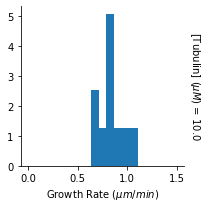

In [33]:
g = sns.FacetGrid(df, row=tubulin, margin_titles=True)
bins = np.linspace(0, 1.5, 20)
g.map(plt.hist, GrowthRate, bins=bins, density=True)

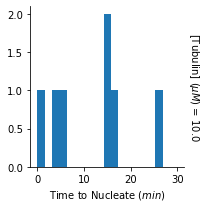

In [34]:
g = sns.FacetGrid(df, row=tubulin, margin_titles=True)
bins = np.linspace(0, 30, 20)
g.map(plt.hist, TimeToNucleate, bins=bins)

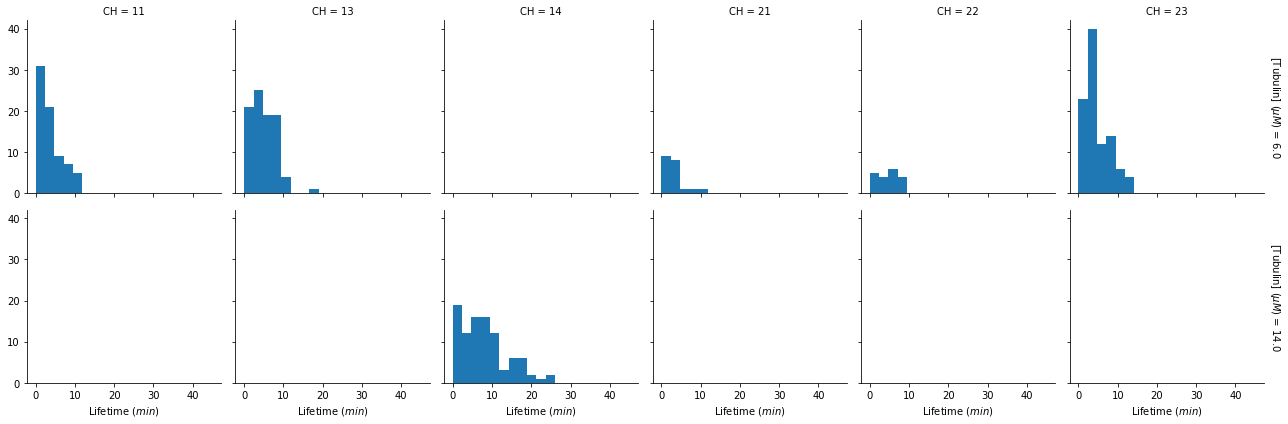

In [59]:
g = sns.FacetGrid(df, row=tubulin, col="CH", margin_titles=True)
bins = np.linspace(0, 45, 20)
g.map(plt.hist, Lifetime, bins=bins)

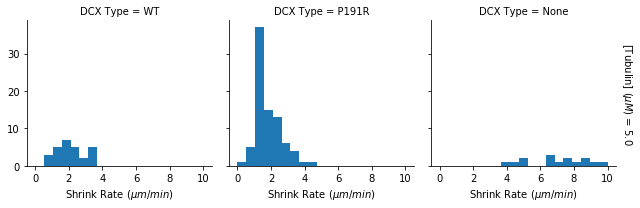

In [53]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 10, 20)
g.map(plt.hist, ShrinkageRate, bins=bins)